# A. Getting Started

In [1]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
from sklearn import metrics

In [2]:
# Data Collection
data=pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")
data.dtypes

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

# B. Data Understanding
Our predictor or target variable will be 'SEVERITYCODE' because it is used to measure the severity of an accident from 0 to 4 within the dataset. Attributes used to weigh the severity of an accident are 'WEATHER', 'ROADCOND' and 'LIGHTCOND'.

Severity codes are as follows:
```
0 : Little to no Probability (Clear Conditions)
1 : Very Low Probability - Chance or Property Damage
2 : Low Probability - Chance of Injury
3 : Mild Probability - Chance of Serious Injury
4 : High Probability - Chance of Fatality
```

# C. Extract Dataset & Convert
In it's original form, this data is not fit for analysis. For one, there are many columns that we will not use for this model. Also, most of the features are of type object, when they should be numerical type.

We must use label encoding to covert the features to our desired data type

In [3]:
# Drop all columns with no predictive value for the context of this project
colData = data.drop(columns = ['OBJECTID', 'SEVERITYCODE.1', 'REPORTNO', 'INCKEY', 'COLDETKEY', 
              'X', 'Y', 'STATUS','ADDRTYPE',
              'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
              'EXCEPTRSNDESC', 'SEVERITYDESC', 'INCDATE',
              'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
              'SDOT_COLDESC', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
              'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY',
              'CROSSWALKKEY', 'HITPARKEDCAR', 'PEDCOUNT', 'PEDCYLCOUNT',
              'PERSONCOUNT', 'VEHCOUNT', 'COLLISIONTYPE',
              'SPEEDING', 'UNDERINFL', 'INATTENTIONIND'])

# Label Encoding
# Convert column to category
colData["WEATHER"] = colData["WEATHER"].astype('category')
colData["ROADCOND"] = colData["ROADCOND"].astype('category')
colData["LIGHTCOND"] = colData["LIGHTCOND"].astype('category')

# Assign variable to new column for analysis
colData["WEATHER_CAT"] = colData["WEATHER"].cat.codes
colData["ROADCOND_CAT"] = colData["ROADCOND"].cat.codes
colData["LIGHTCOND_CAT"] = colData["LIGHTCOND"].cat.codes

colData.head(5)

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEATHER_CAT,ROADCOND_CAT,LIGHTCOND_CAT
0,2,Overcast,Wet,Daylight,4,8,5
1,1,Raining,Wet,Dark - Street Lights On,6,8,2
2,1,Overcast,Dry,Daylight,4,0,5
3,1,Clear,Dry,Daylight,1,0,5
4,2,Raining,Wet,Daylight,6,8,5


Now let's check the data types of the new columns in our dataframe. Moving forward, we will only use the new columns for our analysis.

In [4]:
colData.dtypes

SEVERITYCODE        int64
WEATHER          category
ROADCOND         category
LIGHTCOND        category
WEATHER_CAT          int8
ROADCOND_CAT         int8
LIGHTCOND_CAT        int8
dtype: object

## C.1. Analyzing Value Counts

In [5]:
colData["SEVERITYCODE"].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [6]:
colData["WEATHER"].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [7]:
colData["ROADCOND"].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [8]:
colData["LIGHTCOND"].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [9]:
data.dropna(axis=0, inplace=True)

## C.2. Balancing the Dataset
Our target variable SEVERITYCODE is only 42% balanced. In fact, severitycode in class 1 is nearly three times the size of class 2.

We can fix this by downsampling the majority class.

In [10]:
from sklearn.utils import resample

# Seperate majority and minority classes
colData_majority = colData[colData.SEVERITYCODE==1]
colData_minority = colData[colData.SEVERITYCODE==2]

#Downsample majority class
colData_majority_downsampled = resample(colData_majority,
                                        replace=False,
                                        n_samples=58188,
                                        random_state=123)

# Combine downsampled minority class with downsampled majority class
colData_balanced = pd.concat([colData_majority_downsampled, colData_minority])

# Display new class counts
colData_balanced.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

# D. Methodology
Our data is now ready to be fed into machine learning models.
We will use the following models:

### 1. K-Nearest Neighbor (KNN)
KNN will help us predict the severity code of an outcome by finding the most similar to data point within k distance.

### 2. Decision Tree
A decision tree model gives us a layout of all possible outcomes so we can fully analyze the consequences of a decision. It context, the decision tree observes all possible outcomes of different weather conditions.

### 3. Logistic Regression
Because our dataset only provides us with two severity code outcomes, our model will only predict one of those two classes. This makes our data binary, which is perfect to use with logistic regression.

## Initialization

* Define X and y
* Normalize the dataset
* Train-Test Split

In [11]:
# define X and y
X = np.asarray(colData_balanced[['WEATHER_CAT', 'ROADCOND_CAT', 'LIGHTCOND_CAT']])
y = np.asarray(colData_balanced['SEVERITYCODE'])

In [12]:
# normailze dataset
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.15236718,  1.52797946, -1.21648407],
       [-0.67488   , -0.67084969,  0.42978835],
       [ 2.61416492,  1.25312582,  2.07606076],
       [-0.67488   , -0.67084969,  0.42978835],
       [-0.67488   , -0.67084969,  0.42978835]])

In [13]:
# test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (81463, 3) (81463,)
Test set: (34913, 3) (34913,)


## D.1. K-Nearest Neighbor (KNN)

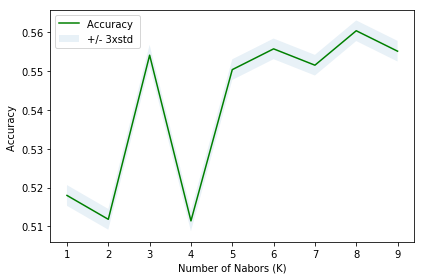

The best accuracy was with 0.56 with k= 8


In [14]:
# Finding the best k-value
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", round(mean_acc.max(), 3), "with k=", mean_acc.argmax()+1)

In [15]:
#Train Model & Predict  
k = mean_acc.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

Kyhat = neigh.predict(X_test)
Kyhat[0:5]

array([2, 2, 1, 1, 2])

## D.2. Decision Tree

In [16]:
# Building the Decision Tree
from sklearn.tree import DecisionTreeClassifier
colDataTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
colDataTree
colDataTree.fit(X_train,y_train)
predTree = colDataTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5664365709048206


In [17]:
# Train Model & Predict
DTyhat = colDataTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

[2 2 1 1 2]
[2 2 1 1 1]


## D.3. Logistic Regression

In [18]:
# Building the LR Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=6, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
# Train Model & Predicr
LRyhat = LR.predict(X_test)
LRyhat

array([1, 2, 1, ..., 2, 2, 2])

In [20]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.57295252, 0.42704748],
       [0.47065071, 0.52934929],
       [0.67630201, 0.32369799],
       ...,
       [0.46929132, 0.53070868],
       [0.47065071, 0.52934929],
       [0.46929132, 0.53070868]])

# E. Result
Now we check the accuracy of out models.

In [21]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### K-Nearest Neighbor

In [22]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, Kyhat)

0.5604502620800275

In [23]:
# F1-SCORE
f1_score(y_test, Kyhat, average='macro')

0.5517390361760366

### Decision Tree

In [24]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, DTyhat)

0.5664365709048206

In [25]:
# F1-SCORE
f1_score(y_test, DTyhat, average='macro')

0.5450597937389444

### Logistic Regression

In [26]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, LRyhat)

0.5260218256809784

In [27]:
# F1-SCORE
f1_score(y_test, LRyhat, average='macro')

0.511602093963383

In [28]:
# LOGLOSS
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.6849535383198887

# F. Discussion
In the beginning of this notebook, we had categorical data that was of type 'object'. This is not a data type that we could have fed through an algorithm, so label encoding was used to created new classes that were of type int8; a numerical data type.

After solving that issue we were presented with another - imbalanced data. As mentioned earlier, class 1 was nearly three times larger than class 2. The solution to this was downsampling the majority class with sklearn's resample tool. We downsampled to match the minority class exactly with 58188 values each.

Once we analyzed and cleaned the data, it was then fed through three ML models; K-Nearest Neighbor, Decision Tree and Logistic Regression. Although the first two are ideal for this project, logistic regression made the most sense because of its binary nature.

Evaluation metrics used to test the accuracy of our models were jaccard index, f-1 score and logloss for logistic regression. Choosing different k, max depth and hyperamater C values helped to improve our accuracy to be the best possible.

### Conclusion
***Based on historical data from weather conditions pointing to certain classes, we can conclude that particular weather conditions have a somewhat impact on whether or not travel could result in property damage (class 1) or injury (class 2)***

# G. Summary
Here is the summary of the scores reported in the evaluation step:

| Algorithm | Jaccard | F1 Score | LogLoss|
| :-------- | :------ | :------- | :----- |
| KNN | 0.56 | 0.55 | NA |
| Descision Tree | 0.56 | 0.54 | NA |
| Logistic Regression | 0.52 | 0.51 | 0.68 |